In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
df=pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [9]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [10]:
df=df.dropna()

In [11]:
df.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [20]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],utc=True)
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday

In [21]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'pickup_hour', 'pickup_weekday'],
      dtype='object')

In [19]:
# Haversine formula to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # Distance in kilometers

In [22]:
df['distance'] = haversine(df['pickup_latitude'], df['pickup_longitude'], 
                           df['dropoff_latitude'], df['dropoff_longitude'])


In [23]:
df = df.drop(['Unnamed: 0', 'key'], axis=1)

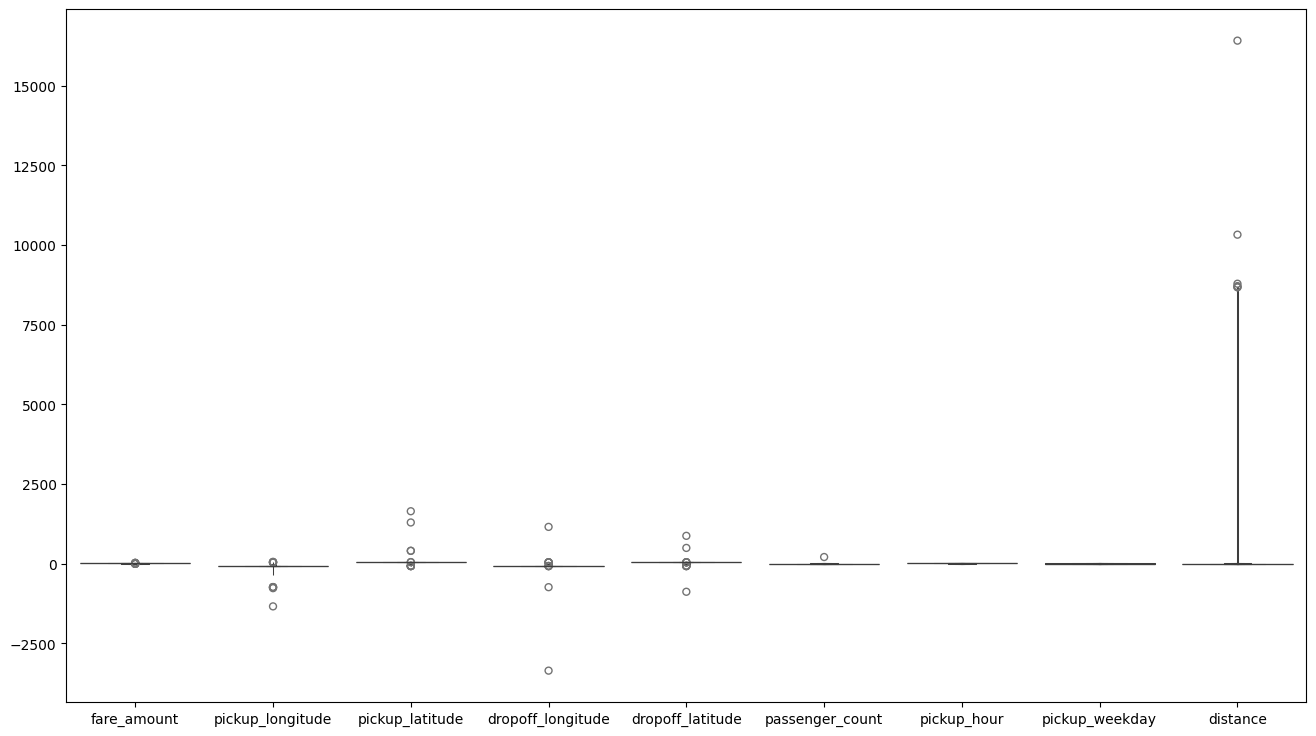

In [36]:
plt.figure(figsize=(16,9))
sns.boxenplot(df)
plt.show()

In [37]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(data, columns):
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        data = data[~((data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR)))]
    return data

# Specify the columns to check for outliers
columns_to_check = ['fare_amount', 'passenger_count', 'distance']

# Remove outliers from the specified columns
df = remove_outliers_iqr(df, columns_to_check)


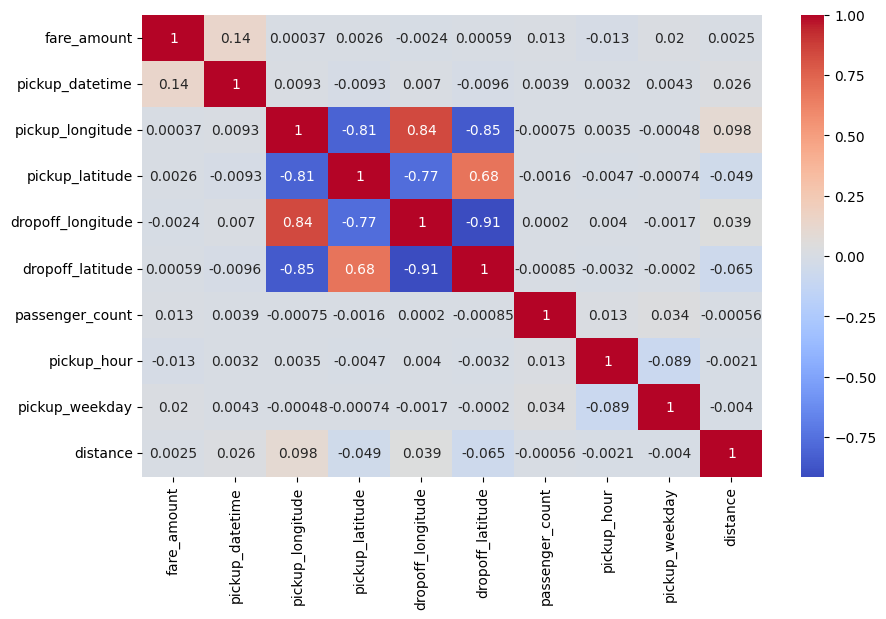

In [25]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [27]:
X = df[['pickup_hour', 'pickup_weekday', 'distance', 'passenger_count']]
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

In [29]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

In [30]:
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
lin_r2 = r2_score(y_test, y_pred_lin)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)    

In [31]:
print(f"Linear Regression - RMSE: {lin_rmse:.2f}, R²: {lin_r2:.2f}")
print(f"Random Forest Regression - RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

Linear Regression - RMSE: 4.14, R²: 0.00
Random Forest Regression - RMSE: 2.49, R²: 0.64
